Aluna: Monica Maria Funk Drechsler

NUSP: 11275391

Neste trabalho iremos utilizar a UNet para realizar a segmentação de imagens de retinas, separando as veias do resto. Para isto, utilizamos SGD e Adam para treinar e comparamos as suas performances. Logo após, comparamos o uso de softmax ou sigmoide na saída da classificação e utilizamos o método de acrescentar peso a métrica como uma forma de lidar com dados desbalanceados. Além disso verificamos se, alterando o tamanho do passo ou adicionando um threshould na classificação pela softmax apresentamos um melhor ou pior desempenho. Por fim, fizemos o data augmentation e verificamos como os novos dados se saíram no treinamento.  

# Import das bibliotecas

In [1]:
import requests #Para obter os dados através de link
import zipfile #Para unzipar os dados
import os #Para operar dentre as páginas de arquivo
import torch #Para utilizar recursos ao longo do código
import torch.nn as nn #Para produzir as redes neurais
from torchvision import transforms # Para realizar transformações nas imagens
import pickle # Para salvar os modelos
from torch.utils.data import Dataset, DataLoader #Para carregar os datasets nos modelos
from sklearn.model_selection import train_test_split #Para separar os dados em treino e teste
import torch.optim as optim #Para otimizar as redes (usar SGD e Adam)
from tqdm import tqdm # Para observar o progresso das iterações
import numpy as np #Para operações matemáticas que aparecem pelo caminho
from PIL import Image #Operar entre imagens
import matplotlib.pyplot as plt #Para plotar gráficos e figuras
from sklearn.metrics import classification_report # Para fazer os relatórios de classificação

# Import e tratamento dos dados

Para baixar os dados, utilizei a sugestão do Erik Miguel de Elias, que disponibilizou no fórum da nossa disciplina o código dele para obter as imagens, alterando apenas o plot das imagens.

In [2]:
# URL pública dos dados, disponibilizada pelo Erik Miguel de Elias
url = 'https://phc.st/drive_png.zip'
destino = '/content/drive_png.zip'  # Caminho para salvar o zip.file
rootfolder = '/content/drive_png' #Caminho local do dataset

# Obter o ZIP e extrair para o arquivo de destino
if not os.path.exists(destino):
  response = requests.get(url)
  with open(destino, 'wb') as file:
      file.write(response.content)
  extract_to = rootfolder
  os.makedirs(extract_to, exist_ok=True)
  with zipfile.ZipFile(destino, 'r') as zip_ref:
      zip_ref.extractall(extract_to)
  print(f'ZIP file extracted to: {extract_to}')


#Para preparar os dados:
class DRIVEDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.input_paths = []
        self.target_paths = []

        for path in sorted(os.listdir(os.path.join(root_dir, 'input'))):
            input_path = os.path.join(root_dir, 'input', path)
            self.input_paths.append(input_path)
        for path in sorted(os.listdir(os.path.join(root_dir, 'target'))):
            target_path = os.path.join(root_dir, 'target', path)
            self.target_paths.append(target_path)

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_path = self.input_paths[idx]
        target_path = self.target_paths[idx]

        input = Image.open(input_path)
        target = Image.open(target_path)

        if self.transform:
            input = self.transform(input)
            target = self.transform(target)
        return input, target


# Para transformar a imagem, estamos usando o Resize de modo a obter uma imagem quadrada/múltipla de 32.
# Quando tentei rodar a Unet na primeira vez, ao juntar a imagem no último copy and crop da rede
# acabei tendo um número ímpar de camadas, fazendo com que a convolução 3 x 3 não consiga chegar no output desejado.
# Por sua vez, o número, 32 = 2^5, surge pela Unet original utilizar 5 camadas de downsampling e upsampling
# Utilizar inputs múltiplos de 32 permite que o downsampling e upsampling comparem as imagens pixel a pixel
# tendo a mesma dimensão. Por tal motivo escolhi o tamanho 576 = 32*18.
transform = transforms.Compose([
    transforms.Resize(size=(576, 576)),
    transforms.ToTensor()
])


# Drive Dataset
train_dataset = DRIVEDataset(root_dir=f'{rootfolder}/training',
                              transform=transform)
test_dataset = DRIVEDataset(root_dir=f'{rootfolder}/test',
                              transform=transform)

#Carregar para o pytorch
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


ZIP file extracted to: /content/drive_png


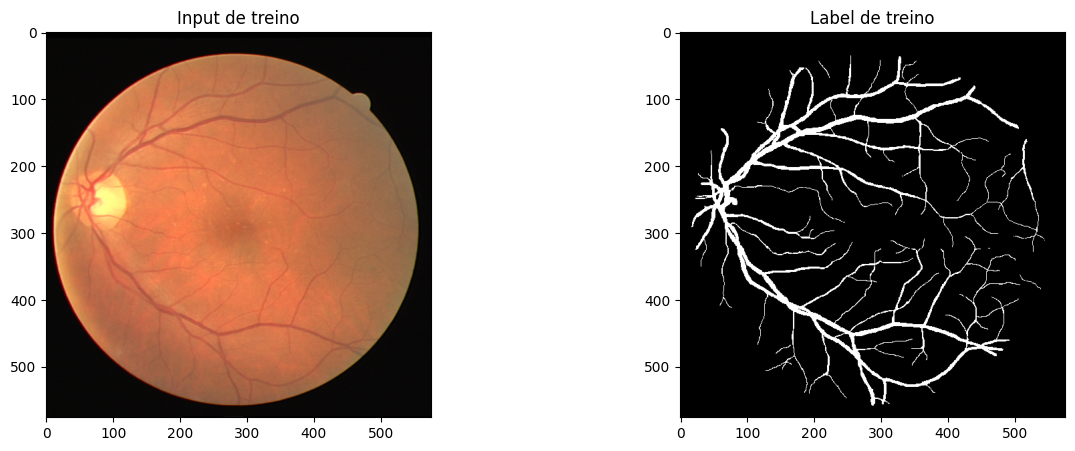

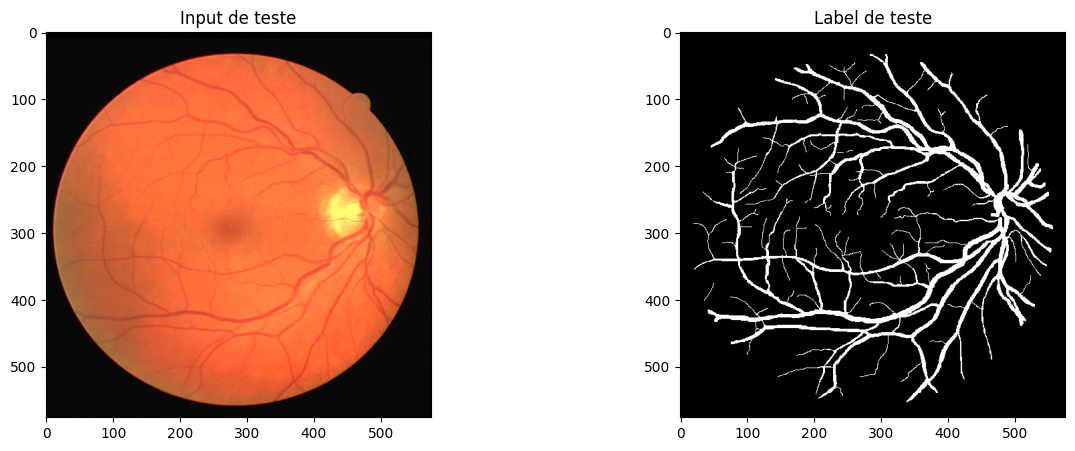

In [3]:
# Ver os dados de treino
image, target = train_loader.dataset[0] # acessar o primeiro item no dataset
image_trein = image.permute(1, 2, 0).numpy() # Converter o tensor da imagem para um array NumPy
target_trein = np.squeeze(target) # Converter o tensor da imagem para um array NumPy

# Exibir a imagem usando Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_trein)
axes[0].set_title("Input de treino")
axes[1].imshow(target_trein, cmap="gray")
axes[1].set_title("Label de treino")
plt.show()

#Ver os dados de teste
image, target = test_loader.dataset[1] # acessar item no dataset
image_test = image.permute(1, 2, 0).numpy()
target_test = np.squeeze(target)

# Exibir a imagem usando Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_test)
axes[0].set_title("Input de teste")
axes[1].imshow(target_test, cmap="gray")
axes[1].set_title("Label de teste")
plt.show()


# Preparação da rede

Modelo da U-Net:

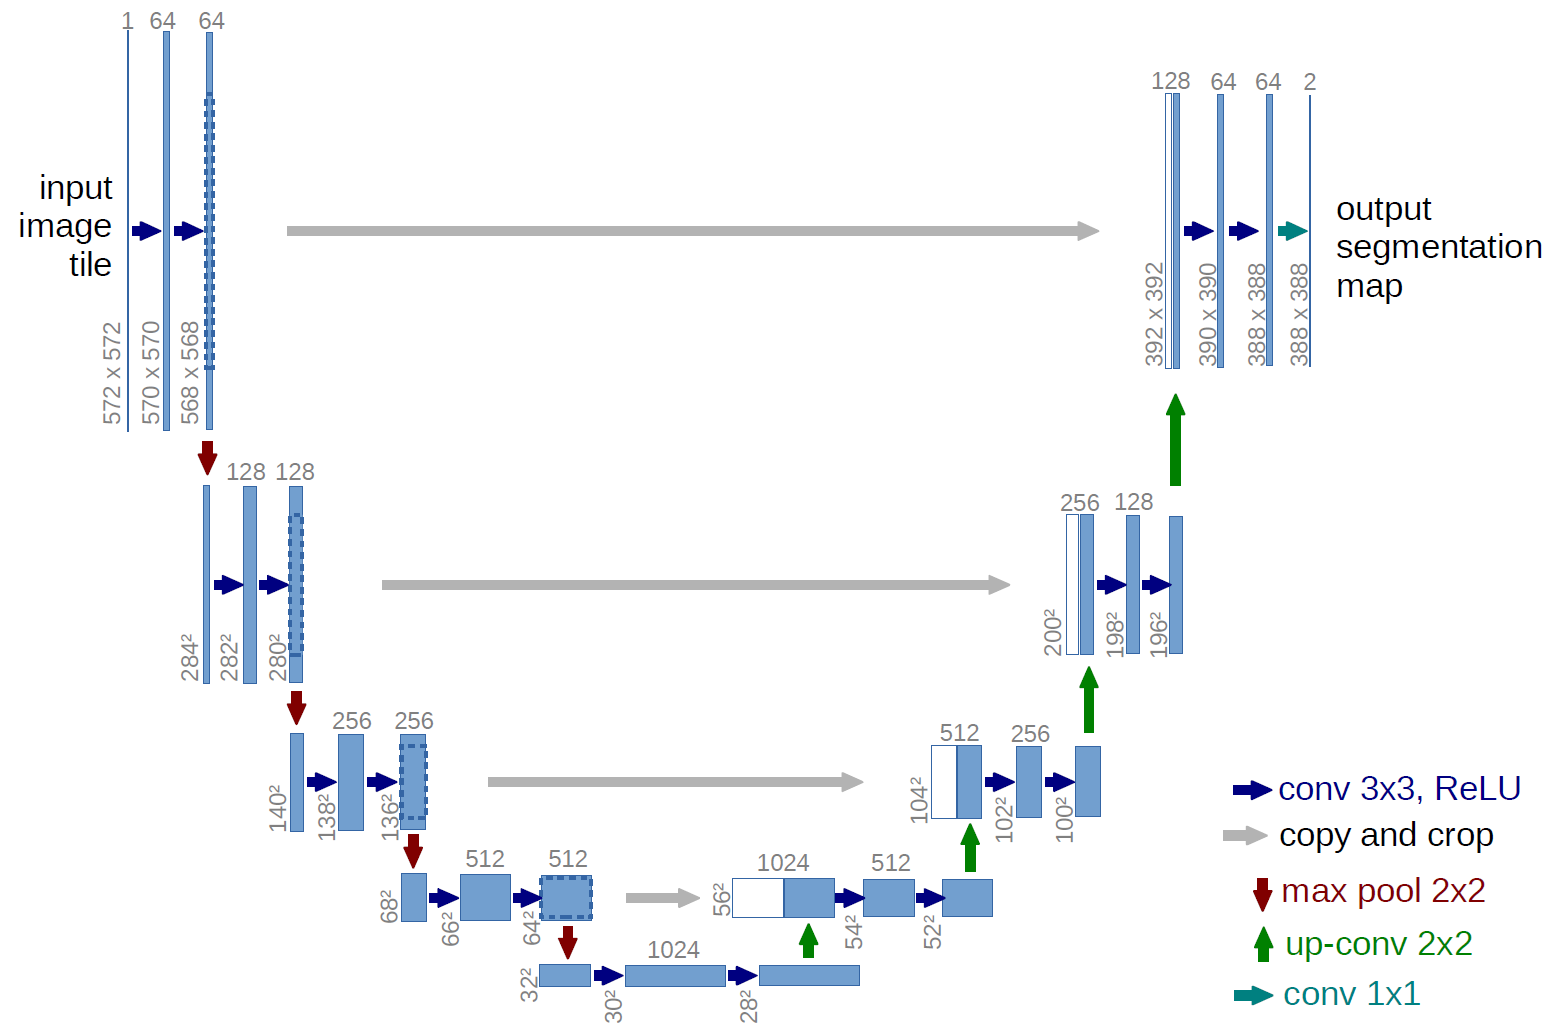

Usando como referência o modelo da Unet inicial do artigo: https://arxiv.org/pdf/1505.04597

e modo de implementação da Unet feita neste Github: https://github.com/tequila28/Unet_based-segmentation/tree/main

In [4]:
class DoubleConv(nn.Module): #Primeiro, definimos a dupla convolução, para facilitar a construção da rede
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self,inn,out):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down1 = DoubleConv(inn, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.down5 = DoubleConv(512, 1024)
        self.upcon1   = DoubleConv(1024,512)
        self.upcon2   = DoubleConv(512,256)
        self.upcon3   = DoubleConv(256,128)
        self.upcon4   = DoubleConv(128,64)
        self.up1 = nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),nn.BatchNorm2d(512),nn.ReLU(inplace=True))
        self.up2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),nn.BatchNorm2d(256),nn.ReLU(inplace=True))
        self.up3 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),nn.BatchNorm2d(128),nn.ReLU(inplace=True))
        self.up4 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),nn.BatchNorm2d(64),nn.ReLU(inplace=True))
        self.up5 = nn.Conv2d(64, out, kernel_size=1)
    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.maxpool(x1)
        x3 = self.down2(x2)
        x4 = self.maxpool(x3)
        x5 = self.down3(x4)
        x6 = self.maxpool(x5)
        x7 = self.down4(x6)
        x8 = self.maxpool(x7)
        x9 = self.down5(x8)
        # Decoder
        x = self.up1(x9)
        x = torch.cat([x, x7], dim=1)
        x=self.upcon1(x)
        x = self.up2(x)
        x = torch.cat([x, x5], dim=1)
        x=self.upcon2(x)
        x = self.up3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.upcon3(x)
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x=self.upcon4(x)
        x = self.up5(x)
        return x

# Treinando o modelo


### Usando SGD e sigmóide

Neste primeiro caso iremos treinar usando SGD em 15 épocas com learning rate de 0.0001 e a medida de erro BCE with Logits Loss com ativação sigmóide.

In [5]:
# Hiperparâmetros
learning_rate = 0.001
num_epochs = 15
batch_size = 5

# Dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # Unet com 3 canal de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.SGD(model.parameters(), lr=learning_rate) #Utilizando SGD como otimizador
criterion = nn.BCEWithLogitsLoss()  # Ainda utilizando o Binary Cross Entropy considerando a sigmoide.

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definir o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")


Epoch 1/15: 100%|██████████| 10/10 [00:08<00:00,  1.22batch/s, Loss=0.663]


Epoch 1/15, Train Loss: 0.6720


Epoch 2/15: 100%|██████████| 10/10 [00:06<00:00,  1.63batch/s, Loss=0.639]


Epoch 2/15, Train Loss: 0.6484


Epoch 3/15: 100%|██████████| 10/10 [00:06<00:00,  1.66batch/s, Loss=0.625]


Epoch 3/15, Train Loss: 0.6293


Epoch 4/15: 100%|██████████| 10/10 [00:06<00:00,  1.65batch/s, Loss=0.607]


Epoch 4/15, Train Loss: 0.6131


Epoch 5/15: 100%|██████████| 10/10 [00:06<00:00,  1.65batch/s, Loss=0.587]


Epoch 5/15, Train Loss: 0.5977


Epoch 6/15: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s, Loss=0.575]


Epoch 6/15, Train Loss: 0.5823


Epoch 7/15: 100%|██████████| 10/10 [00:06<00:00,  1.52batch/s, Loss=0.564]


Epoch 7/15, Train Loss: 0.5698


Epoch 8/15: 100%|██████████| 10/10 [00:06<00:00,  1.59batch/s, Loss=0.557]


Epoch 8/15, Train Loss: 0.5575


Epoch 9/15: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s, Loss=0.537]


Epoch 9/15, Train Loss: 0.5444


Epoch 10/15: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s, Loss=0.524]


Epoch 10/15, Train Loss: 0.5337


Epoch 11/15: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s, Loss=0.524]


Epoch 11/15, Train Loss: 0.5233


Epoch 12/15: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s, Loss=0.505]


Epoch 12/15, Train Loss: 0.5125


Epoch 13/15: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s, Loss=0.495]


Epoch 13/15, Train Loss: 0.5028


Epoch 14/15: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s, Loss=0.488]


Epoch 14/15, Train Loss: 0.4937


Epoch 15/15: 100%|██████████| 10/10 [00:06<00:00,  1.59batch/s, Loss=0.478]

Epoch 15/15, Train Loss: 0.4857


Podemos ver que o decrescimento da Loss de treino foi pequeno...

In [6]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions = torch.round(torch.sigmoid(outputs))

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94   6054049
         1.0       0.21      0.08      0.12    581471

    accuracy                           0.89   6635520
   macro avg       0.56      0.53      0.53   6635520
weighted avg       0.85      0.89      0.87   6635520



Através do Classification Report podemos perceber o desbalanceamento dos dados de classe 1/veias, que possuem uma presença muito menor (581471 em comparação a 6054049). Além disto, vemos que a precisão e o recall desta classe estão baixos, e que a precisão da classe 0 está alta enquanto o seu recall está menor. Isto nos diz que o modelo está prevendo uma maior presença da classe 0 do que ela realmente existe.  Vamos tentar visualizar isto em nosso modelo:  

In [7]:
def visualize_prediction(model, test_loader, device): #Definindo uma função para visualizar a diferença entre o input, o label e a predição do label
  model.eval()  # Define o modelo para o modo de avaliação
  with torch.no_grad():
      for image, target in test_loader:
          image = image.to(device)
          target = target.to(device)

          outputs = model(image)
          predictions = torch.round(torch.sigmoid(outputs))  # Arredondando as saídas para obter uma máscara binária

          # Move os dados para a CPU e converte para NumPy arrays
          image = image.cpu().numpy()
          target = target.cpu().numpy()
          predictions = predictions.cpu().numpy()

          # Plota o input, o label e a predição
          fig, axes = plt.subplots(1, 3, figsize=(15, 5))
          axes[0].imshow(np.transpose(image[0], (1, 2, 0)))
          axes[0].set_title("Imagem de Entrada")
          axes[1].imshow(np.squeeze(target[0]), cmap="gray")
          axes[1].set_title("Label real")
          axes[2].imshow(np.squeeze(predictions[0]), cmap="gray")
          axes[2].set_title("Predição do Modelo")
          plt.show()

          break  # Para visualizar apenas uma imagem

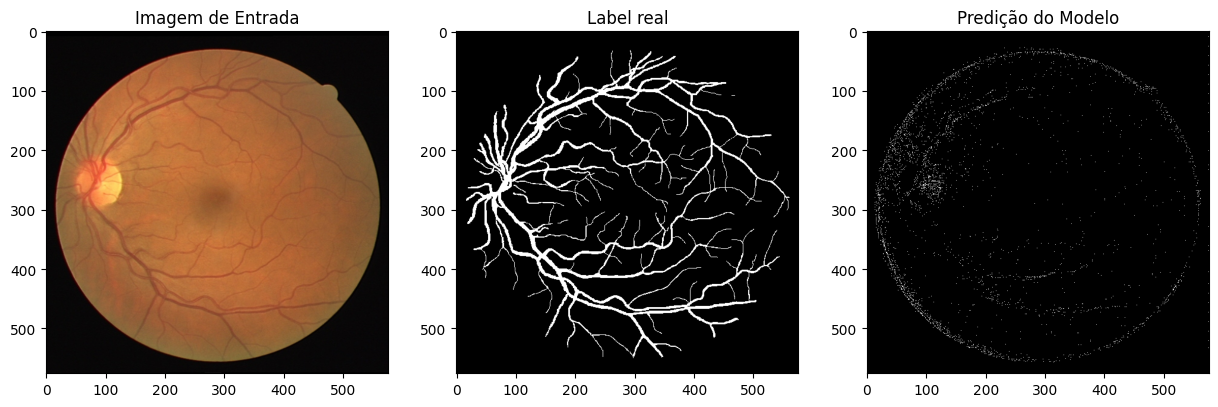

In [8]:
visualize_prediction(model, test_loader, device)

Podemos ver que a predição realmente está bem ruim, conseguindo prever apenas uma das veias centrais e alguns pontos aleatórios (fazendo jus ao Stochastic em SGD).

In [15]:
#Salvando o modelo usando o pickle devido aos problemas com memória do Colab
os.makedirs('/content/drive/My Drive/', exist_ok = True)
with open('/content/drive/My Drive/modelo_treinadoSGD.pkl', 'wb') as f:
    pickle.dump(model, f)

### Usando Adam e sigmoide

Neste caso iremos treinar usando o modo Adam de otimização, em 15 épocas com learning rate de 0.0001 e a medida de erro BCE with Logits Loss com ativação sigmóide.

In [ ]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.0001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Utilizando Adam como método de otimização
criterion = nn.BCEWithLogitsLoss()  # Medida de erro Cross Entropy para caso binário considerando ativação sigmóide

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definindo o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")


Epoch 1/15: 100%|██████████| 10/10 [00:07<00:00,  1.34batch/s, Loss=0.545]


Epoch 1/15, Train Loss: 0.6302


Epoch 2/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.465]


Epoch 2/15, Train Loss: 0.5000


Epoch 3/15: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s, Loss=0.449]


Epoch 3/15, Train Loss: 0.4613


Epoch 4/15: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s, Loss=0.429]


Epoch 4/15, Train Loss: 0.4365


Epoch 5/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.407]


Epoch 5/15, Train Loss: 0.4115


Epoch 6/15: 100%|██████████| 10/10 [00:06<00:00,  1.48batch/s, Loss=0.402]


Epoch 6/15, Train Loss: 0.3975


Epoch 7/15: 100%|██████████| 10/10 [00:06<00:00,  1.49batch/s, Loss=0.37]


Epoch 7/15, Train Loss: 0.3779


Epoch 8/15: 100%|██████████| 10/10 [00:07<00:00,  1.42batch/s, Loss=0.354]


Epoch 8/15, Train Loss: 0.3651


Epoch 9/15: 100%|██████████| 10/10 [00:06<00:00,  1.50batch/s, Loss=0.369]


Epoch 9/15, Train Loss: 0.3542


Epoch 10/15: 100%|██████████| 10/10 [00:06<00:00,  1.49batch/s, Loss=0.359]


Epoch 10/15, Train Loss: 0.3496


Epoch 11/15: 100%|██████████| 10/10 [00:07<00:00,  1.42batch/s, Loss=0.337]


Epoch 11/15, Train Loss: 0.3395


Epoch 12/15: 100%|██████████| 10/10 [00:07<00:00,  1.31batch/s, Loss=0.333]


Epoch 12/15, Train Loss: 0.3291


Epoch 13/15: 100%|██████████| 10/10 [00:06<00:00,  1.43batch/s, Loss=0.322]


Epoch 13/15, Train Loss: 0.3244


Epoch 14/15: 100%|██████████| 10/10 [00:06<00:00,  1.43batch/s, Loss=0.311]


Epoch 14/15, Train Loss: 0.3179


Epoch 15/15: 100%|██████████| 10/10 [00:07<00:00,  1.38batch/s, Loss=0.301]

Epoch 15/15, Train Loss: 0.3095


Vamos agora ver as métricas de resultado deste treinamento nas amostras de teste

In [ ]:
model.eval()  #Avaliar o resultado dos dados no modelo
all_predictions = []
all_labels = []

# Interagir nos dados de teste de modo a obter as predições e o erro delas
with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions =  torch.round(torch.sigmoid(outputs))  #Como a classificação é binária, a predição acaba sendo a sigmoide do output

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())

# Convertendo as predições para arrays numpy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

#Para conseguirmos gerar o relatório de classificação
print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97   6054049
         1.0       0.70      0.73      0.71    581471

    accuracy                           0.95   6635520
   macro avg       0.84      0.85      0.84   6635520
weighted avg       0.95      0.95      0.95   6635520



É possível ver que, de modo geral, o comportamento deste treinamento teve um resultado razóavel. A precisão da classe 0 continua alta, mas com um recall semelhante, ou seja, o modelo está acertando mais onde realmente se trata da classe 0. No entanto, apesar da melhoria em comparação a SGD, ainda temos valores menores para a classe 1, tanto em precisão quanto em recall, dizendo que não estamos classificando todos os que ali existem. Podemos verificar isto na imagem abaixo:

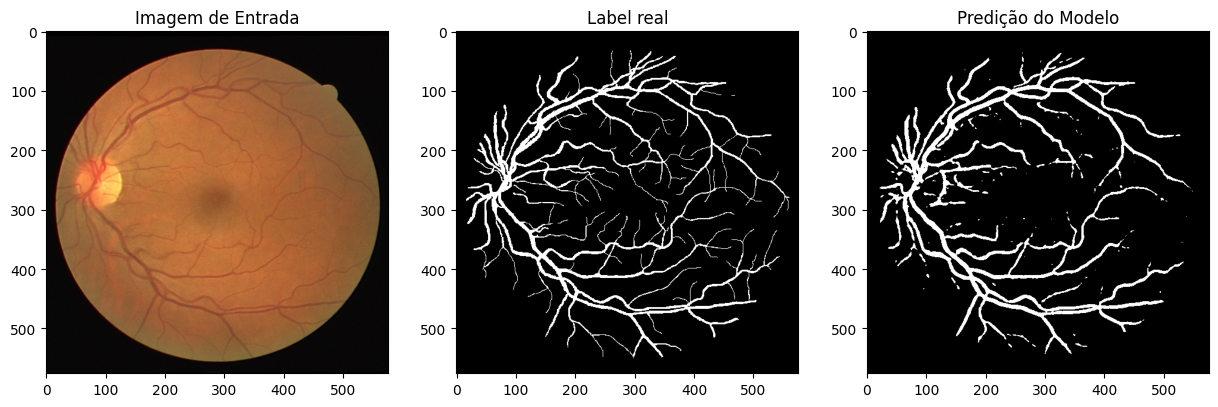

In [ ]:
visualize_prediction(model, test_loader, device)

Como podemos ver pelas imagens, o modelo conseguiu classificar as veias maiores, faltando as veias menores, que justamente fazem a precisão e o recall da classe 1 um pouco menor.  

O melhor comportamento do Adam em comparação ao SGD pode ser pela taxa de aprendizado adaptativa e por envolver dados redundantes (que, segundo a referência:https://pt.d2l.ai/chapter_optimization/adam.html ele lida melhor).

In [ ]:
#Salvando o modelo localmente usando pickle (devido aos problemas com o uso de memória no Colab)
os.makedirs('/content/drive/My Drive/', exist_ok = True)
with open('/content/drive/My Drive/modelo_treinado.pkl', 'wb') as f:
    pickle.dump(model, f)

#### E se eu colocar um learning rate maior?

Considerando uma taxa de aprendizado 0.001

In [33]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Utilizando Adam como método de otimização
criterion = nn.BCEWithLogitsLoss()  # Medida de erro Cross Entropy para caso binário considerando ativação sigmóide

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definindo o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/15: 100%|██████████| 10/10 [00:06<00:00,  1.59batch/s, Loss=0.426]


Epoch 1/15, Train Loss: 0.5254


Epoch 2/15: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s, Loss=0.377]


Epoch 2/15, Train Loss: 0.3927


Epoch 3/15: 100%|██████████| 10/10 [00:06<00:00,  1.60batch/s, Loss=0.373]


Epoch 3/15, Train Loss: 0.3457


Epoch 4/15: 100%|██████████| 10/10 [00:06<00:00,  1.59batch/s, Loss=0.307]


Epoch 4/15, Train Loss: 0.3090


Epoch 5/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.241]


Epoch 5/15, Train Loss: 0.2699


Epoch 6/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.266]


Epoch 6/15, Train Loss: 0.2435


Epoch 7/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.205]


Epoch 7/15, Train Loss: 0.2187


Epoch 8/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.19]


Epoch 8/15, Train Loss: 0.1961


Epoch 9/15: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s, Loss=0.186]


Epoch 9/15, Train Loss: 0.1800


Epoch 10/15: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s, Loss=0.185]


Epoch 10/15, Train Loss: 0.1639


Epoch 11/15: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s, Loss=0.168]


Epoch 11/15, Train Loss: 0.1598


Epoch 12/15: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s, Loss=0.174]


Epoch 12/15, Train Loss: 0.1521


Epoch 13/15: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s, Loss=0.149]


Epoch 13/15, Train Loss: 0.1498


Epoch 14/15: 100%|██████████| 10/10 [00:06<00:00,  1.48batch/s, Loss=0.132]


Epoch 14/15, Train Loss: 0.1395


Epoch 15/15: 100%|██████████| 10/10 [00:06<00:00,  1.55batch/s, Loss=0.132]

Epoch 15/15, Train Loss: 0.1380


In [34]:
model.eval()  #Avaliar o resultado dos dados no modelo
all_predictions = []
all_labels = []

# Interagir nos dados de teste de modo a obter as predições e o erro delas
with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions =  torch.round(torch.sigmoid(outputs))  #Como a classificação é binária, a predição acaba sendo a sigmoide do output

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())

# Convertendo as predições para arrays numpy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

#Para conseguirmos gerar o relatório de classificação
print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97   6054049
         1.0       0.94      0.41      0.58    581471

    accuracy                           0.95   6635520
   macro avg       0.94      0.71      0.77   6635520
weighted avg       0.95      0.95      0.94   6635520



Vemos que o precision da classe 1 aumentou bastante com a taxa de aprendizado maior, bem como o recall da classe 0, no entanto, o recall da classe 1 piorou bastante, passando de 0.73 para 0.41. Isto nos diz que apesar de estar acertando os dados que são corretos e são falsos, estamos tendo um aumento no número de falsos negativos. Vale a pena chamar a atenção também na diminuição do erro.

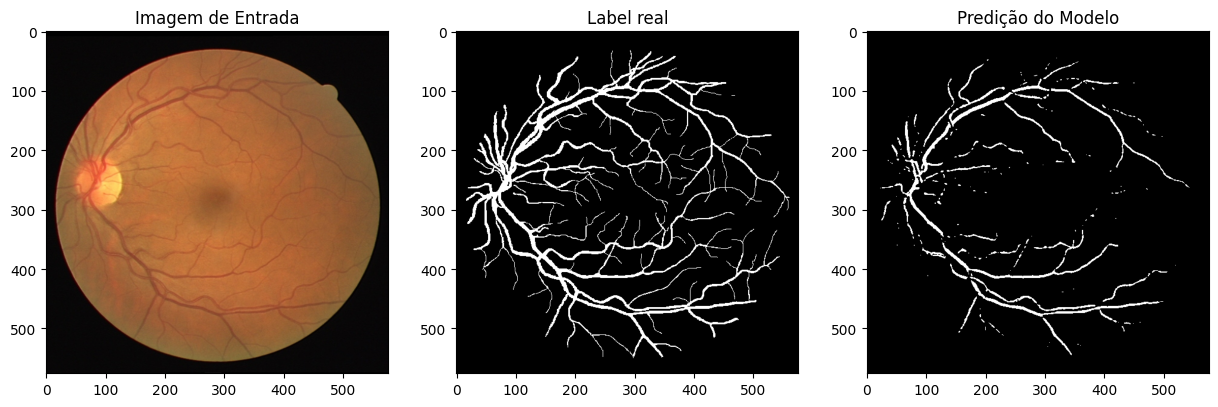

In [36]:
visualize_prediction(model, test_loader, device)

Considerando a taxa de aprendizado 0.01

In [37]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.01
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Utilizando Adam como método de otimização
criterion = nn.BCEWithLogitsLoss()  # Medida de erro Cross Entropy para caso binário considerando ativação sigmóide

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definindo o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/15: 100%|██████████| 10/10 [00:07<00:00,  1.37batch/s, Loss=0.258]


Epoch 1/15, Train Loss: 0.3670


Epoch 2/15: 100%|██████████| 10/10 [00:06<00:00,  1.45batch/s, Loss=0.232]


Epoch 2/15, Train Loss: 0.2664


Epoch 3/15: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s, Loss=0.245]


Epoch 3/15, Train Loss: 0.2462


Epoch 4/15: 100%|██████████| 10/10 [00:06<00:00,  1.55batch/s, Loss=0.222]


Epoch 4/15, Train Loss: 0.2275


Epoch 5/15: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s, Loss=0.216]


Epoch 5/15, Train Loss: 0.2084


Epoch 6/15: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s, Loss=0.186]


Epoch 6/15, Train Loss: 0.2103


Epoch 7/15: 100%|██████████| 10/10 [00:06<00:00,  1.58batch/s, Loss=0.172]


Epoch 7/15, Train Loss: 0.2005


Epoch 8/15: 100%|██████████| 10/10 [00:06<00:00,  1.56batch/s, Loss=0.153]


Epoch 8/15, Train Loss: 0.1893


Epoch 9/15: 100%|██████████| 10/10 [00:06<00:00,  1.57batch/s, Loss=0.166]


Epoch 9/15, Train Loss: 0.1820


Epoch 10/15: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s, Loss=0.192]


Epoch 10/15, Train Loss: 0.1864


Epoch 11/15: 100%|██████████| 10/10 [00:06<00:00,  1.55batch/s, Loss=0.192]


Epoch 11/15, Train Loss: 0.1763


Epoch 12/15: 100%|██████████| 10/10 [00:06<00:00,  1.47batch/s, Loss=0.191]


Epoch 12/15, Train Loss: 0.1837


Epoch 13/15: 100%|██████████| 10/10 [00:06<00:00,  1.53batch/s, Loss=0.164]


Epoch 13/15, Train Loss: 0.1757


Epoch 14/15: 100%|██████████| 10/10 [00:06<00:00,  1.48batch/s, Loss=0.166]


Epoch 14/15, Train Loss: 0.1564


Epoch 15/15: 100%|██████████| 10/10 [00:06<00:00,  1.48batch/s, Loss=0.185]

Epoch 15/15, Train Loss: 0.1695


In [38]:
model.eval()  #Avaliar o resultado dos dados no modelo
all_predictions = []
all_labels = []

# Interagir nos dados de teste de modo a obter as predições e o erro delas
with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions =  torch.round(torch.sigmoid(outputs))  #Como a classificação é binária, a predição acaba sendo a sigmoide do output

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())

# Convertendo as predições para arrays numpy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

#Para conseguirmos gerar o relatório de classificação
print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97   6054049
         1.0       0.87      0.31      0.46    581471

    accuracy                           0.94   6635520
   macro avg       0.90      0.65      0.71   6635520
weighted avg       0.93      0.94      0.92   6635520



Aqui, embora novamente tenhamos uma diminuição no erro e tenhamos um recall de 1.00 na classe 0, o recall da classe 1 piorou mais ainda, bem como a precisão. Isto se transfere na imagem como veias sem detecção e partes que não são veias detectadas como se fossem.  

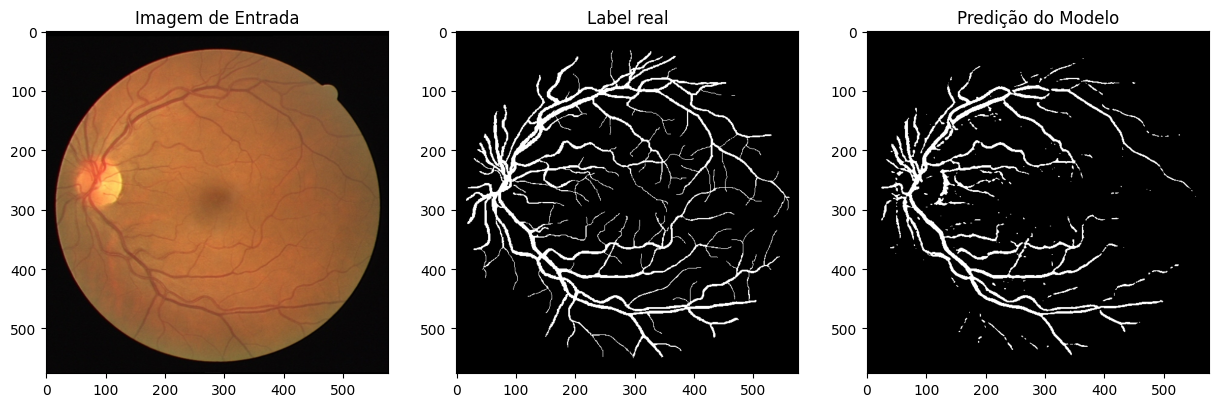

In [39]:
visualize_prediction(model, test_loader, device)

### Usando softmax ao invés de sigmoide


Por ser uma classificação binária, a medida de erro BCEWithLogisticLoss já inclui a Binary Cross Entropy com a ativação sigmoide e é numericamente mais estável (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), no entanto, para alterar para a ativação softmax, precisaremos utilizar a medida de erro BCELoss e incluir uma camada a mais que será a ativação pela softmax.

In [4]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.0001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()  # Altera a medida de erro para Binary Cross Entropy, sem ativação sigmoide

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definir o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            saida = outputs.softmax(dim=0) #Acrescenta um passo antes da medida de erro, pois precisa aplicar a softmax antes de medir
            loss = criterion(saida, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcula a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/15: 100%|██████████| 10/10 [11:00<00:00, 66.07s/batch, Loss=0.686]


Epoch 1/15, Train Loss: 0.7003


Epoch 2/15: 100%|██████████| 10/10 [10:40<00:00, 64.02s/batch, Loss=0.671]


Epoch 2/15, Train Loss: 0.6815


Epoch 3/15: 100%|██████████| 10/10 [10:35<00:00, 63.51s/batch, Loss=0.681]


Epoch 3/15, Train Loss: 0.6684


Epoch 4/15: 100%|██████████| 10/10 [10:35<00:00, 63.53s/batch, Loss=0.672]


Epoch 4/15, Train Loss: 0.6606


Epoch 5/15: 100%|██████████| 10/10 [10:32<00:00, 63.27s/batch, Loss=0.661]


Epoch 5/15, Train Loss: 0.6616


Epoch 6/15: 100%|██████████| 10/10 [10:29<00:00, 62.96s/batch, Loss=0.658]


Epoch 6/15, Train Loss: 0.6537


Epoch 7/15: 100%|██████████| 10/10 [10:31<00:00, 63.19s/batch, Loss=0.641]


Epoch 7/15, Train Loss: 0.6531


Epoch 8/15: 100%|██████████| 10/10 [10:32<00:00, 63.28s/batch, Loss=0.657]


Epoch 8/15, Train Loss: 0.6499


Epoch 9/15: 100%|██████████| 10/10 [10:29<00:00, 62.98s/batch, Loss=0.637]


Epoch 9/15, Train Loss: 0.6492


Epoch 10/15: 100%|██████████| 10/10 [10:28<00:00, 62.90s/batch, Loss=0.642]


Epoch 10/15, Train Loss: 0.6463


Epoch 11/15: 100%|██████████| 10/10 [10:30<00:00, 63.02s/batch, Loss=0.636]


Epoch 11/15, Train Loss: 0.6456


Epoch 12/15: 100%|██████████| 10/10 [10:31<00:00, 63.15s/batch, Loss=0.643]


Epoch 12/15, Train Loss: 0.6453


Epoch 13/15: 100%|██████████| 10/10 [10:32<00:00, 63.23s/batch, Loss=0.65]


Epoch 13/15, Train Loss: 0.6440


Epoch 14/15: 100%|██████████| 10/10 [10:30<00:00, 63.03s/batch, Loss=0.633]


Epoch 14/15, Train Loss: 0.6432


Epoch 15/15: 100%|██████████| 10/10 [10:34<00:00, 63.47s/batch, Loss=0.645]

Epoch 15/15, Train Loss: 0.6429


Por ter só uma saída da rede, ao aplicar CrossEntropyLoss obtive Loss=-0 e que não se alterava no treinamento. Apenas aplicando Binary Cross Entropy é que realmente consegui medir erro e, ao aplicar a softmax com dim=0 que obteve real diferença na diminuição da Loss.

In [5]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions = torch.round(torch.softmax(outputs, dim=0))

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96   6054049
         1.0       0.98      0.20      0.34    581471

    accuracy                           0.93   6635520
   macro avg       0.96      0.60      0.65   6635520
weighted avg       0.93      0.93      0.91   6635520



Usar a softmax ao invés da sigmoide apresentou um ótimo resultado na precisão da classe 1, que aumentou para 98%. No entanto, veja que o recall está muito baixo, tendo uma média pior em comparação ao treino usando softmax. Isto se deve por ter muitos falsos positivos. Abaixo podemos ver melhor o que aconteceu:

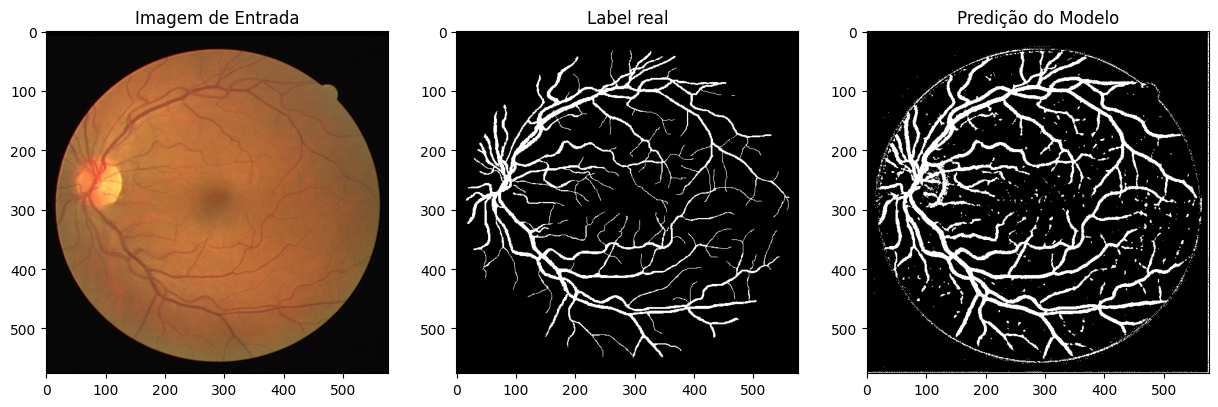

In [8]:
visualize_prediction(model, test_loader, device)

Ou seja, usando a softmax, estamos classificando veias onde elas nem existem, por isto, o valor do recall está tão baixo, estamos superclassificando elas. Ainda, isto pode acontecer pelo resultado numérico após a saída da Unet. Pode ser que a softmax, ao ser avaliada nestes valores, esteja apresentando valores maiores e que acabam sendo classificados como 1 mesmo não os sendo. Aplicando um threshould diferente na predição do modelo poderíamos obter outro resultado.

In [9]:
#Salvando o modelo usando pickle
os.makedirs('/content/drive/My Drive/', exist_ok = True)
with open('/content/drive/My Drive/modelo_treinado_softmax.pkl', 'wb') as f:
    pickle.dump(model, f)

#### E se eu colocar um threshold na classificação?

Colocando Threshold > 0.5

In [26]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        softmax_outputs = outputs.softmax(dim=0)
        threshold = 0.75  # Definindo um limite para classificação
        predictions = np.max(softmax_outputs.cpu().numpy(), axis=0) >= threshold
        predictions = (softmax_outputs > threshold).float()

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96   6054049
         1.0       1.00      0.04      0.07    581471

    accuracy                           0.92   6635520
   macro avg       0.96      0.52      0.51   6635520
weighted avg       0.92      0.92      0.88   6635520



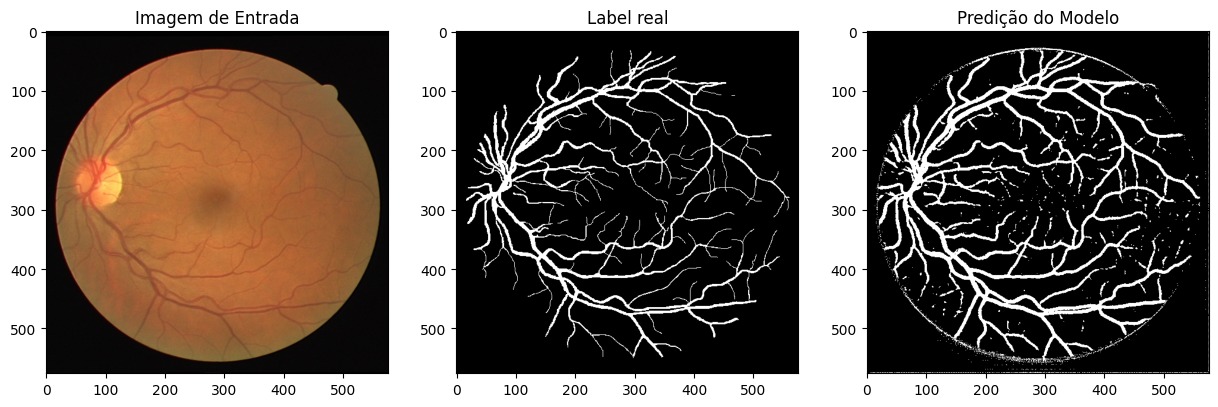

In [27]:
visualize_prediction(model, test_loader, device)

Colocando Threshold< 0.5

In [28]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        softmax_outputs = outputs.softmax(dim=0)
        threshold = 0.25  # Definindo um limite para classificação
        predictions = np.max(softmax_outputs.cpu().numpy(), axis=0) >= threshold
        predictions = (softmax_outputs > threshold).float()

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97   6054049
         1.0       0.90      0.49      0.64    581471

    accuracy                           0.95   6635520
   macro avg       0.93      0.74      0.80   6635520
weighted avg       0.95      0.95      0.94   6635520



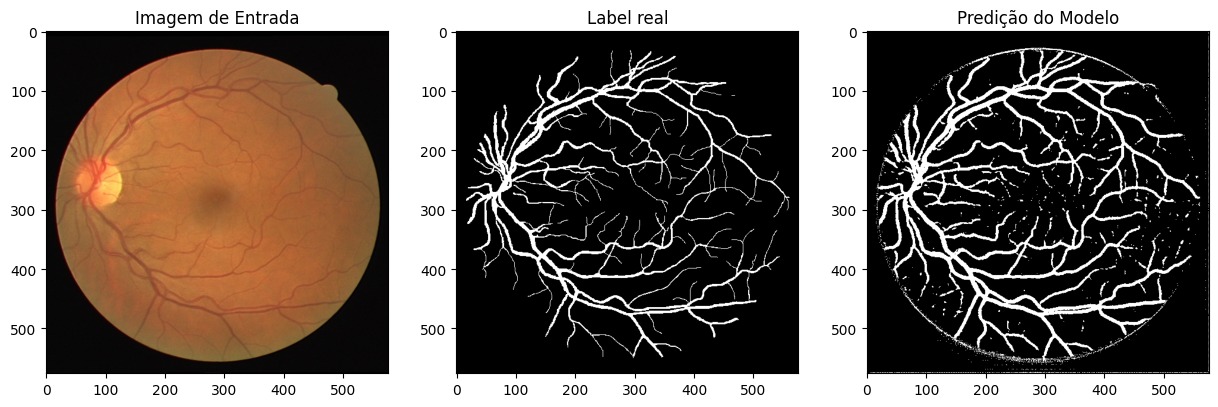

In [29]:
visualize_prediction(model, test_loader, device)

### Tentando lidar com os dados desbalanceados:

Ao pesquisar sobre medidas de erro, para trocar entre sigmoide e softmax e a influência do BCEwithLogisticLoss em comparação com o CrossEntropyLoss e o BCELoss, me deparei com a utilização de pesos na loss como uma forma de lidar com dados desbalanceados:  https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

Neste documento eles apresentam a seguinte regra de calcular o peso conforme a quantidade de amostras $$\mbox{peso por classe } i = \frac{\mbox{total de amostras}}{\mbox{amostras da classe } i \times \mbox{qtde de classes}}$$

Desta forma, o peso da primeira classe vai ser dado por
$$\mbox{peso da classe 0}=\frac{6635520}{6054049\times 2}=0,5480233146444635647977$$


Já o peso da segunda classe vai ser dada por:
$$\mbox{peso da classe 1}=\frac{6635520}{581471\times 2}= 5,70580476068453972769$$

In [ ]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.0001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
weight = torch.tensor([5.7]).to(device)  # Ajustando os pesos conforme a regra
criterion = nn.BCEWithLogitsLoss(weight=weight)

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definir o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/15: 100%|██████████| 10/10 [00:08<00:00,  1.23batch/s, Loss=2.8]


Epoch 1/15, Train Loss: 3.1157


Epoch 2/15: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s, Loss=2.39]


Epoch 2/15, Train Loss: 2.5501


Epoch 3/15: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s, Loss=2.08]


Epoch 3/15, Train Loss: 2.2162


Epoch 4/15: 100%|██████████| 10/10 [00:06<00:00,  1.54batch/s, Loss=1.92]


Epoch 4/15, Train Loss: 2.0053


Epoch 5/15: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s, Loss=1.85]


Epoch 5/15, Train Loss: 1.9037


Epoch 6/15: 100%|██████████| 10/10 [00:06<00:00,  1.51batch/s, Loss=1.76]


Epoch 6/15, Train Loss: 1.8043


Epoch 7/15: 100%|██████████| 10/10 [00:06<00:00,  1.47batch/s, Loss=1.78]


Epoch 7/15, Train Loss: 1.7349


Epoch 8/15: 100%|██████████| 10/10 [00:06<00:00,  1.46batch/s, Loss=1.65]


Epoch 8/15, Train Loss: 1.6753


Epoch 9/15: 100%|██████████| 10/10 [00:06<00:00,  1.43batch/s, Loss=1.6]


Epoch 9/15, Train Loss: 1.6323


Epoch 10/15: 100%|██████████| 10/10 [00:07<00:00,  1.41batch/s, Loss=1.56]


Epoch 10/15, Train Loss: 1.6022


Epoch 11/15: 100%|██████████| 10/10 [00:07<00:00,  1.40batch/s, Loss=1.67]


Epoch 11/15, Train Loss: 1.5637


Epoch 12/15: 100%|██████████| 10/10 [00:07<00:00,  1.38batch/s, Loss=1.5]


Epoch 12/15, Train Loss: 1.5175


Epoch 13/15: 100%|██████████| 10/10 [00:07<00:00,  1.39batch/s, Loss=1.48]


Epoch 13/15, Train Loss: 1.4926


Epoch 14/15: 100%|██████████| 10/10 [00:07<00:00,  1.36batch/s, Loss=1.43]


Epoch 14/15, Train Loss: 1.4572


Epoch 15/15: 100%|██████████| 10/10 [00:07<00:00,  1.41batch/s, Loss=1.41]

Epoch 15/15, Train Loss: 1.4262


In [ ]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions = torch.round(torch.sigmoid(outputs))

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98   6054049
         1.0       0.78      0.73      0.76    581471

    accuracy                           0.96   6635520
   macro avg       0.88      0.85      0.87   6635520
weighted avg       0.96      0.96      0.96   6635520



Podemos ver que, em comparação ao treinamento sem utilizar os pesos e utilizando o Adam, realmente tivemos um resultado um pouco melhor, principalmente na classe 1.  

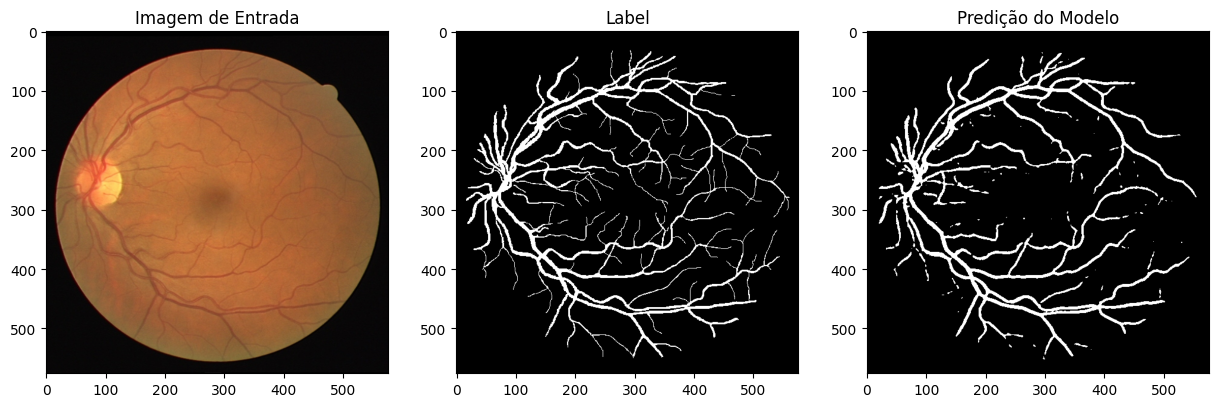

In [ ]:
visualize_prediction(model, test_loader, device)

O que é visível nas imagens, ele conseguiu detectar veias menores em comparação ao método sem peso, mas ainda não sendo perfeito.

#### E se eu considerar o primeiro peso?

In [ ]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.0001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
weight = torch.tensor([0.5]).to(device)  # Ajustando os pesos conforme a regra
criterion = nn.BCEWithLogitsLoss(weight=weight)

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()  # Definir o modelo para modo de treinamento
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for image, target in train_loader:
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 7669 has 14.73 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 38.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Apresenta erro de memória. O mesmo ocorre ao tentar utilizar os pesos para ambas as classes, usando um vetor com duas entradas, acaba a memória antes de iniciar a treinar.  

### Data augmentation

In [9]:
torch.manual_seed(0)

# Define as transformações de data augmentation
data_transforms = transforms.Compose([
    transforms.RandomCrop(size=(544, 544)),
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
    transforms.RandomRotation(10),     # Rotação aleatória de até 10
    transforms.ToTensor()

])
class DRIVEDatasetTransf(Dataset):
  def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.input_paths = []
        self.target_paths = []

        for path in sorted(os.listdir(os.path.join(root_dir, 'input'))):
            input_path = os.path.join(root_dir, 'input', path)
            self.input_paths.append(input_path)
        for path in sorted(os.listdir(os.path.join(root_dir, 'target'))):
            target_path = os.path.join(root_dir, 'target', path)
            self.target_paths.append(target_path)

  def __len__(self):
        return len(self.input_paths)

  def __getitem__(self, idx):
        input_path = self.input_paths[idx]
        target_path = self.target_paths[idx]

        input = Image.open(input_path)
        target = Image.open(target_path)

        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)
        if self.transform:
          input = self.transform(input)

        torch.manual_seed(seed)
        if self.transform:
          target = self.transform(target)

        return input, target


new_train_dataset = DRIVEDatasetTransf(root_dir=f'{rootfolder}/training', transform=data_transforms)
new_test_dataset = DRIVEDatasetTransf(root_dir=f'{rootfolder}/test', transform=data_transforms)

new_train_loader = DataLoader(new_train_dataset, batch_size=2, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=10, shuffle=True)


Vamos ver como ficaram os dados após as transformações:

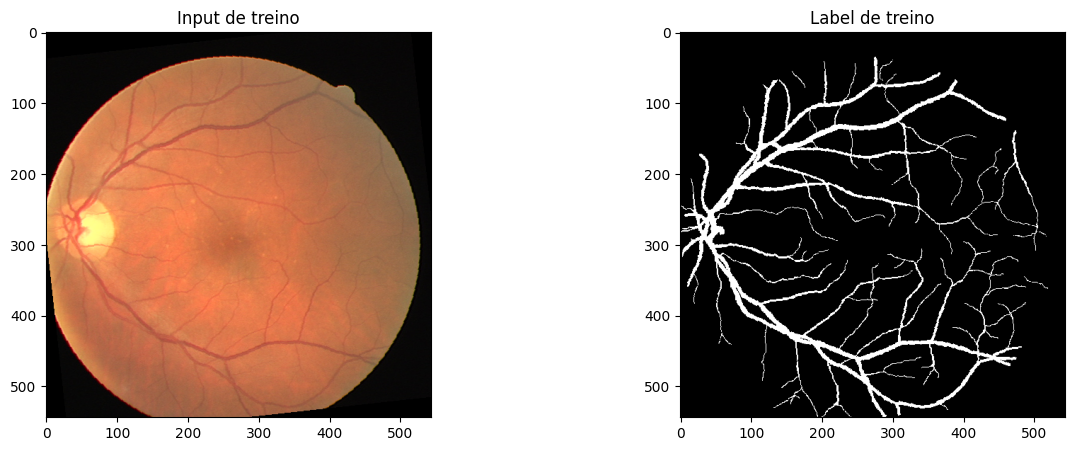

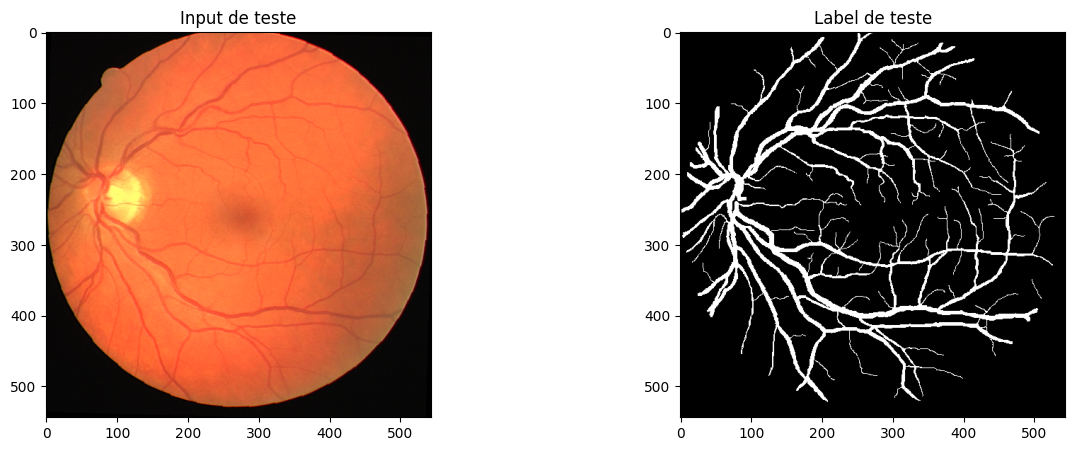

In [10]:
# Ver os dados de treino
image, target = new_train_loader.dataset[0] # acessando a amostra no novo dataset
image_trein = image.permute(1, 2, 0).numpy()
target_trein = np.squeeze(target)

# Exibir a imagem usando Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_trein)
axes[0].set_title("Input de treino")
axes[1].imshow(target_trein, cmap="gray")
axes[1].set_title("Label de treino")
plt.show()

#Ver os dados de teste
image, target = new_test_loader.dataset[1] # acessar item no novo dataset
image_test = image.permute(1, 2, 0).numpy()
target_test = np.squeeze(target)

# Exibir a imagem usando Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image_test)
axes[0].set_title("Input de teste")
axes[1].imshow(target_test, cmap="gray")
axes[1].set_title("Label de teste")
plt.show()


In [11]:
image, target = next(iter(new_train_loader))
print(image.shape)
print(target.shape)

torch.Size([2, 3, 544, 544])
torch.Size([2, 1, 544, 544])


In [12]:
# Defina o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina hiperparâmetros
learning_rate = 0.0001
num_epochs = 15
batch_size = 1


# Instancie o modelo, otimizador e função de perda
model = UNet(3, 1).to(device)  # 3 canais de entrada (RGB) e 1 canal de saída (segmentação binária)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    with tqdm(total=len(new_train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar: #alterando o train_loader
        for image, target in new_train_loader: #alterando o train_loader
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    # Calcule a perda média de treinamento para a época
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")


Epoch 1/15: 100%|██████████| 10/10 [00:06<00:00,  1.65batch/s, Loss=0.578]


Epoch 1/15, Train Loss: 0.6522


Epoch 2/15: 100%|██████████| 10/10 [00:05<00:00,  1.73batch/s, Loss=0.49]


Epoch 2/15, Train Loss: 0.5282


Epoch 3/15: 100%|██████████| 10/10 [00:05<00:00,  1.72batch/s, Loss=0.453]


Epoch 3/15, Train Loss: 0.4676


Epoch 4/15: 100%|██████████| 10/10 [00:05<00:00,  1.74batch/s, Loss=0.416]


Epoch 4/15, Train Loss: 0.4305


Epoch 5/15: 100%|██████████| 10/10 [00:05<00:00,  1.72batch/s, Loss=0.39]


Epoch 5/15, Train Loss: 0.4038


Epoch 6/15: 100%|██████████| 10/10 [00:05<00:00,  1.72batch/s, Loss=0.389]


Epoch 6/15, Train Loss: 0.3857


Epoch 7/15: 100%|██████████| 10/10 [00:05<00:00,  1.72batch/s, Loss=0.363]


Epoch 7/15, Train Loss: 0.3713


Epoch 8/15: 100%|██████████| 10/10 [00:06<00:00,  1.62batch/s, Loss=0.353]


Epoch 8/15, Train Loss: 0.3595


Epoch 9/15: 100%|██████████| 10/10 [00:05<00:00,  1.72batch/s, Loss=0.362]


Epoch 9/15, Train Loss: 0.3540


Epoch 10/15: 100%|██████████| 10/10 [00:05<00:00,  1.69batch/s, Loss=0.334]


Epoch 10/15, Train Loss: 0.3438


Epoch 11/15: 100%|██████████| 10/10 [00:05<00:00,  1.71batch/s, Loss=0.334]


Epoch 11/15, Train Loss: 0.3360


Epoch 12/15: 100%|██████████| 10/10 [00:05<00:00,  1.69batch/s, Loss=0.331]


Epoch 12/15, Train Loss: 0.3286


Epoch 13/15: 100%|██████████| 10/10 [00:05<00:00,  1.70batch/s, Loss=0.329]


Epoch 13/15, Train Loss: 0.3274


Epoch 14/15: 100%|██████████| 10/10 [00:05<00:00,  1.68batch/s, Loss=0.318]


Epoch 14/15, Train Loss: 0.3228


Epoch 15/15: 100%|██████████| 10/10 [00:05<00:00,  1.69batch/s, Loss=0.311]

Epoch 15/15, Train Loss: 0.3145


In [13]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for image, target in new_test_loader:
        image = image.to(device)
        target = target.to(device)

        outputs = model(image)
        predictions = torch.round(torch.sigmoid(outputs))

        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_predictions))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97   5341542
         1.0       0.75      0.71      0.73    577178

    accuracy                           0.95   5918720
   macro avg       0.86      0.84      0.85   5918720
weighted avg       0.95      0.95      0.95   5918720



Ou seja, com o Data augmentation, tivemos uma pequena melhoria em comparação com rodar o Adam normalmente, novamente na parte de classificação das veias. Vamos ver isto visualmente:

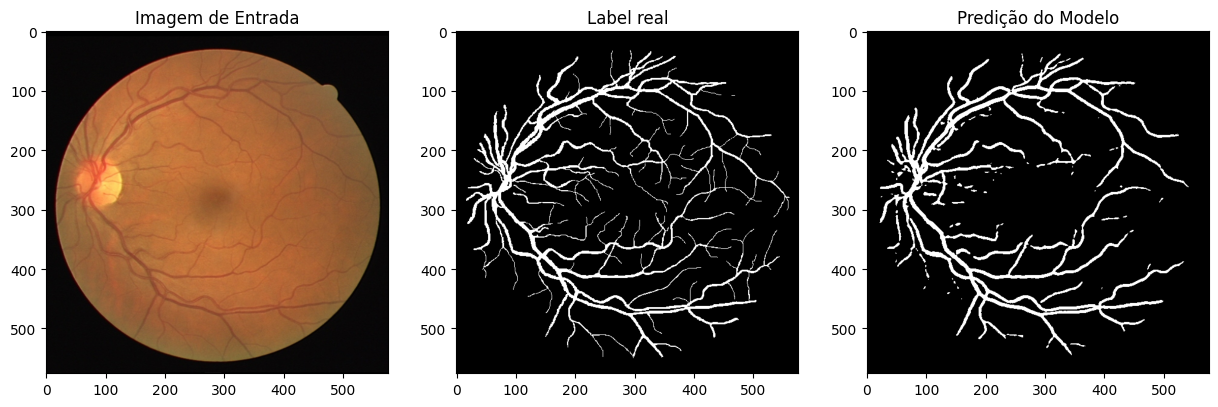

In [14]:
visualize_prediction(model, test_loader, device)

Percebe-se que as veias principais estão mais destacadas, em comparação a outros métodos, mas ainda com dificuldade de encontrar as menores. Talvez, para mais transformações, incluíndo imagens com zooms nas veias pequenas e treinamentos específicos em cimas delas, poderíamos ter resultados ainda mais eficientes.

Ao final, os melhores resultados em termos de acurácia e recall vieram do Adam utilizando peso nas métricas, e de acurácia foi a Softmax, embora ela caracterize mais veias do que existem, tendo recall não tão bom assim para a classe 1.  

Alguns pontos que ficam após este treinamento são: como melhorar ainda mais estes resultados? Será que haveria uma forma de detectar todas as veias pequenas? Quanto poder computacional isso iria requerer? Será que podemos calcular qual a necessidade de poder computacional para um certo tipo de problema?

OBS: Ao longo do código, na maioria dos casos consegui rodar usando a t4 do Colab, no entanto, alguns modelos já não foram mais permitidos, levando assim mais tempo em seus treinos. Apenas deixando claro que isto não está ligado a complexidade deles, tendo em vista que sofreram poucas modificações.

## Referências usadas:

#### Exemplos:
Rede Unet sendo usada para segmentação de retina:
https://www.kaggle.com/code/rahultheogre/retinal-vessel-segmentation-with-u-net

Segmentação de imagem e transformações para Data Augmentation:
https://heartbeat.comet.ml/image-segmentation-with-pytorch-and-comet-1798d3bb005d

Aplicação da Unet para segmentação de retina:
https://github.com/tequila28/Unet_based-segmentation/tree/main


#### Documentação:

BCE vs Cross Entropy:  
https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23

BCE with logistic loss:
https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

Softmax:  
https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

Atribuir peso a BCE para lidar com dados desbalanceados:   
https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75


Além disto, usei o Gemini para tirar dúvidas em códigos, encontrar erros e o que fazer em certas situações (como, quando o Cross Entropy dá 0). As vezes ele não acerta de cara, mas ajuda a encontrar onde pode estar o erro.  

